In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from scipy import stats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation
from scipy.ndimage import gaussian_filter1d
import warnings
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv", index_col=0)
df = df[df.basepath.str.contains("ORproject")]
df

,basepath,basename
280,Z:\Data\ORproject\OR15\day1,day1
281,Z:\Data\ORproject\OR15\day10,day10
282,Z:\Data\ORproject\OR15\day2,day2
283,Z:\Data\ORproject\OR15\day3,day3
284,Z:\Data\ORproject\OR15\day4,day4
285,Z:\Data\ORproject\OR15\hc280118,hc280118
286,Z:\Data\ORproject\OR15\hc300118,hc300118
287,Z:\Data\ORproject\OR18\day1,day1
288,Z:\Data\ORproject\OR18\day2,day2
289,Z:\Data\ORproject\OR18\day3,day3


(8090.0, 8100.0)

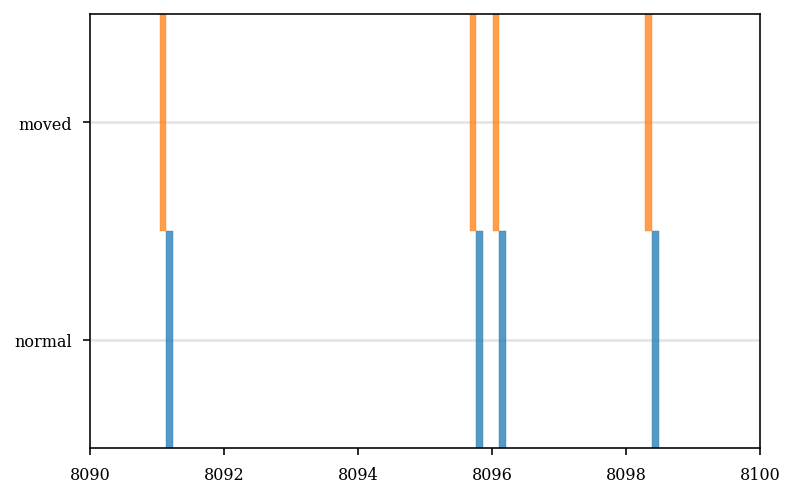

In [332]:
# closed_loop_epoch.expand(.1,direction="start").shrink(.1,direction="stop").starts
from ripple_heterogeneity.utils import custom_plots

events = []
events.append(closed_loop_epoch)
events.append(closed_loop_epoch.expand(.1,direction="start").shrink(.1,direction="stop"))

custom_plots.plot_events(events,["normal","moved"])
plt.xlim(8090,8100)

In [4]:
import warnings
warnings.filterwarnings("ignore")
results = pd.DataFrame()

for basepath in df.basepath:

    manipulation_epochs = loading.load_manipulation(
        basepath, struct_name="optoStim", return_epoch_array=False
    )
    st, cm = loading.load_spikes(basepath, putativeCellType="Pyr", brainRegion="CA1")
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    state_dict = loading.load_SleepState_states(basepath)
    wake_epochs = nel.EpochArray(state_dict["WAKEstate"])

    closed_loop_epoch = nel.EpochArray([manipulation_epochs[manipulation_epochs.ev_label == "closed_loop"][["start","stop"]].values])
    delayed_epoch = nel.EpochArray([manipulation_epochs[manipulation_epochs.ev_label == "delayed"][["start","stop"]].values])


    closed_loop = functions.get_participation(
        st.data,
        closed_loop_epoch[wake_epochs].starts,
        closed_loop_epoch[wake_epochs].stops,
        par_type="firing_rate",
    )
    delayed = functions.get_participation(
        st.data,
        delayed_epoch[wake_epochs].starts,
        delayed_epoch[wake_epochs].stops,
        par_type="firing_rate",
    )
    

    before_closed_loop = functions.get_participation(
        st.data,
        closed_loop_epoch[wake_epochs].expand(.1,direction="start").shrink(.1,direction="stop").starts,
        closed_loop_epoch[wake_epochs].expand(.1,direction="start").shrink(.1,direction="stop").stops,
        par_type="firing_rate",
    )

    if delayed_epoch[wake_epochs].isempty:
        before_delayed = np.empty(delayed.shape)
    else:
        before_delayed = functions.get_participation(
            st.data,
            delayed_epoch[wake_epochs].expand(.1,direction="start").shrink(.1,direction="stop").starts,
            delayed_epoch[wake_epochs].expand(.1,direction="start").shrink(.1,direction="stop").stops,
            par_type="firing_rate",
        )

    temp_df = pd.DataFrame()

    temp_df["baseline_fr"] = np.hstack(
        [st.n_spikes / (st.last_event - st.first_event), st.n_spikes / (st.last_event - st.first_event)]
    )

    temp_df["avg_before_stim_firing_rate"] = np.hstack(
        [before_closed_loop.mean(axis=1), before_delayed.mean(axis=1)]
    )

    temp_df["participation"] = np.hstack(
        [(closed_loop > 0).mean(axis=1), (delayed > 0).mean(axis=1)]
    )
    temp_df["avg_stim_firing_rate"] = np.hstack(
        [closed_loop.mean(axis=1), delayed.mean(axis=1)]
    )

    closed_loop[closed_loop == 0] = np.nan
    delayed[delayed == 0] = np.nan

    temp_df["avg_firing_rate_if_par"] = np.hstack(
        [np.nanmean(closed_loop,axis=1), np.nanmean(delayed,axis=1)]
    )

    temp_df["stim_type"] = np.hstack(
        [
            np.repeat("closed_loop", closed_loop.shape[0]),
            np.repeat("delayed", delayed.shape[0]),
        ]
    )
    temp_df["stim_type"] = temp_df["stim_type"].astype("category")
    temp_df["UID"] = np.hstack([cm.UID, cm.UID])
    temp_df["deepSuperficial"] = np.hstack([cm.deepSuperficial, cm.deepSuperficial])
    temp_df["deepSuperficial"] = temp_df["deepSuperficial"].astype("category")
    temp_df["deepSuperficialDistance"] = np.hstack(
        [cm.deepSuperficialDistance, cm.deepSuperficialDistance]
    )
    results = pd.concat([results, temp_df], ignore_index=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    results["stim_gain"] = results["avg_stim_firing_rate"] / results["baseline_fr"]   
    results["stim_gain_before_during"] = results["avg_stim_firing_rate"] / results["avg_before_stim_firing_rate"]    

results


,baseline_fr,avg_before_stim_firing_rate,participation,avg_stim_firing_rate,avg_firing_rate_if_par,stim_type,UID,deepSuperficial,deepSuperficialDistance,stim_gain,stim_gain_before_during
0,0.034753,0.000000,0.000000,0.000000,NaN,closed_loop,1,middle,-20.000000,0.000000,NaN
1,0.896057,1.860465,0.139535,1.453488,10.416667,closed_loop,2,Deep,-32.592842,1.622094,0.781250
2,0.813525,2.616279,0.087209,1.104651,12.666667,closed_loop,4,middle,0.000000,1.357857,0.422222
3,0.875360,1.395349,0.063953,0.639535,10.000000,closed_loop,5,middle,-2.592842,0.730597,0.458333
4,0.342122,0.639535,0.017442,0.174419,10.000000,closed_loop,6,middle,-15.970780,0.509813,0.272727
...,...,...,...,...,...,...,...,...,...,...,...
2141,0.388939,0.000000,0.000000,0.000000,NaN,delayed,112,Deep,-178.470382,0.000000,NaN
2142,0.288623,0.000000,0.000000,0.000000,NaN,delayed,113,Deep,-88.470382,0.000000,NaN
2143,0.271007,0.105263,0.000000,0.000000,NaN,delayed,114,Deep,-78.470382,0.000000,0.000000
2144,2.391339,3.263158,0.378947,5.578947,14.722222,delayed,115,Superficial,44.599494,2.332981,1.709677


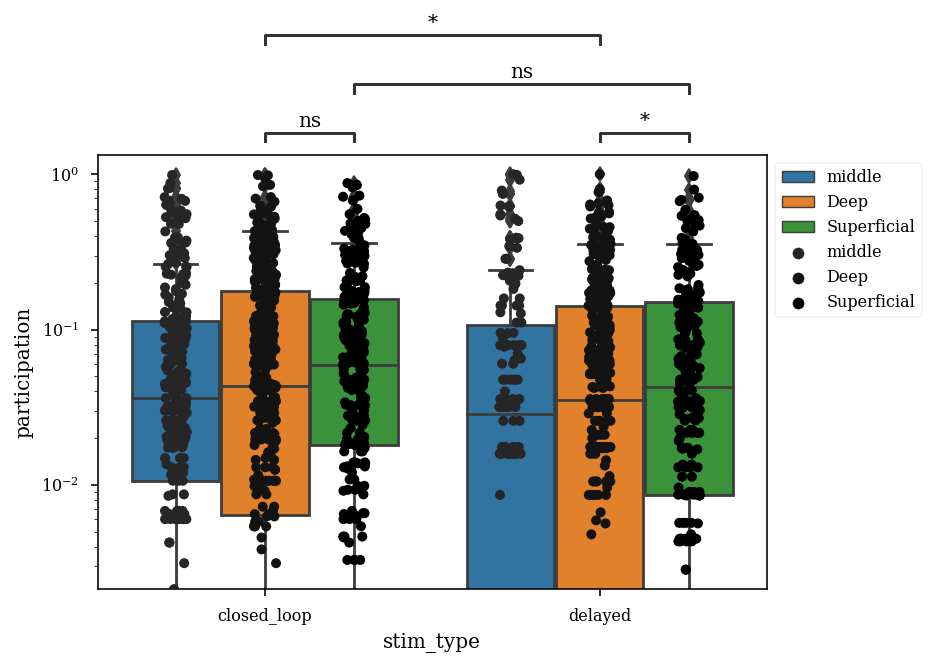

In [5]:
sns.boxplot(x='stim_type',y='participation',hue="deepSuperficial",data=results)
sns.stripplot(x='stim_type',y='participation',hue="deepSuperficial",data=results,dodge=True,color="black")
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "Superficial")),
    (("delayed", "Deep"),("delayed", "Superficial")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "Superficial"),("delayed", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="stim_type",
    y="participation",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()

In [16]:
# plt.figure(figsize=functions.set_size("thesis", fraction=.5, subplots=(3, 1)))

# group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
# sns.set_palette(sns.color_palette(group_colors.values()))

# results["constant"] = 1
# sns.boxplot(x='constant',y='participation',hue="deepSuperficial",data=results.query("stim_type=='closed_loop' & deepSuperficial != 'middle'"),showfliers=False)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


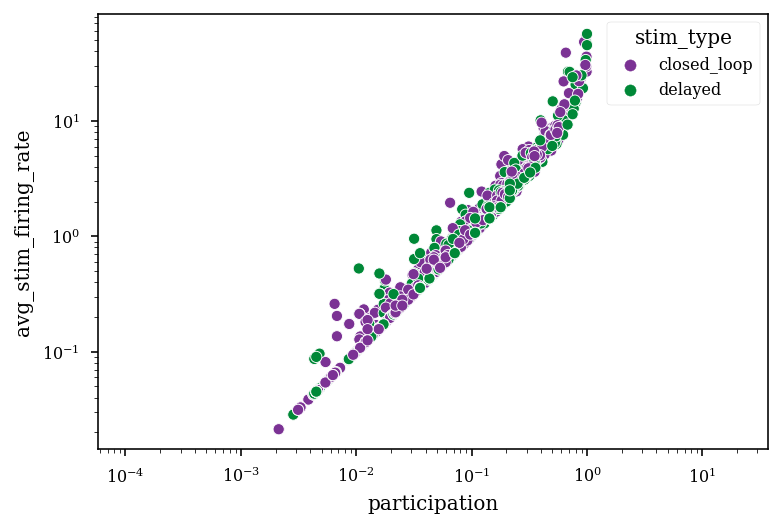

In [344]:
sns.scatterplot(x='participation',y='avg_stim_firing_rate',hue="stim_type",data=results)
plt.axis("equal")
plt.yscale('log')
plt.xscale('log')

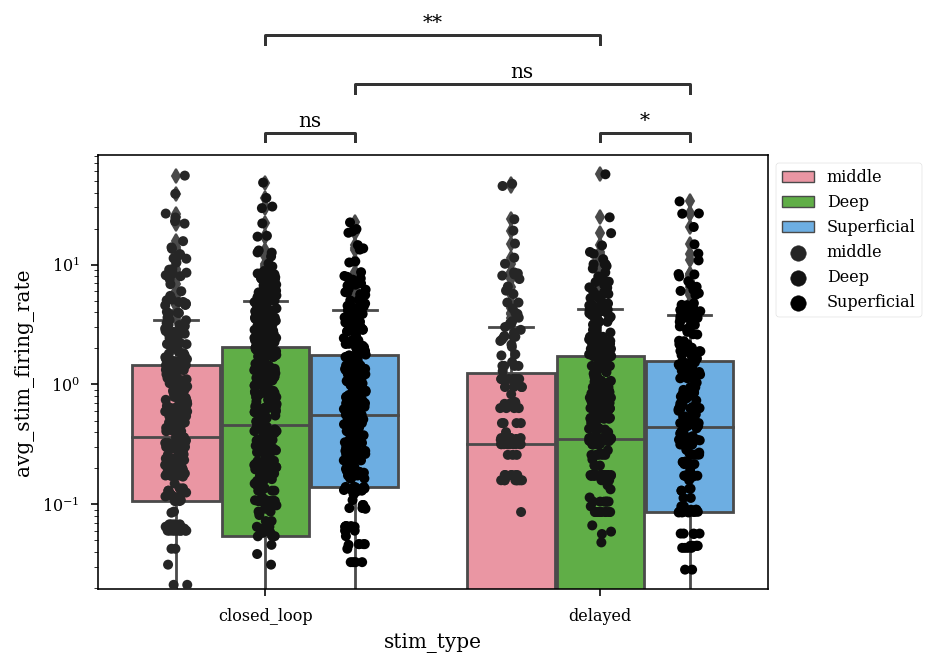

In [345]:
sns.boxplot(x='stim_type',y='avg_stim_firing_rate',hue="deepSuperficial",data=results)
sns.stripplot(x='stim_type',y='avg_stim_firing_rate',hue="deepSuperficial",data=results,dodge=True,color="black")
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "Superficial")),
    (("delayed", "Deep"),("delayed", "Superficial")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "Superficial"),("delayed", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="stim_type",
    y="avg_stim_firing_rate",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()


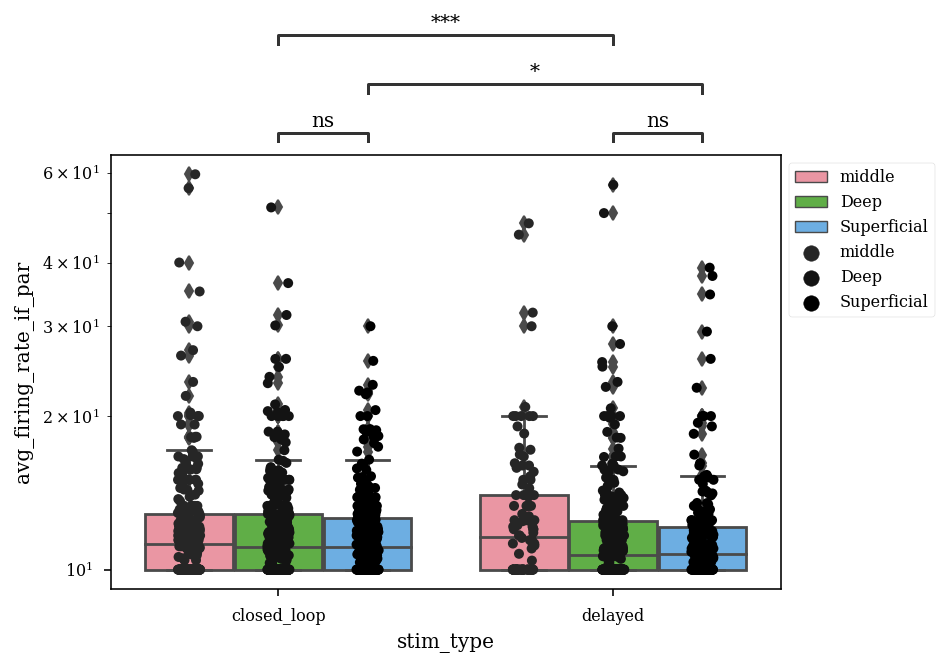

In [346]:
sns.boxplot(x='stim_type',y='avg_firing_rate_if_par',hue="deepSuperficial",data=results)
sns.stripplot(x='stim_type',y='avg_firing_rate_if_par',hue="deepSuperficial",data=results,dodge=True,color="black")
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "Superficial")),
    (("delayed", "Deep"),("delayed", "Superficial")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "Superficial"),("delayed", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="stim_type",
    y="avg_firing_rate_if_par",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()


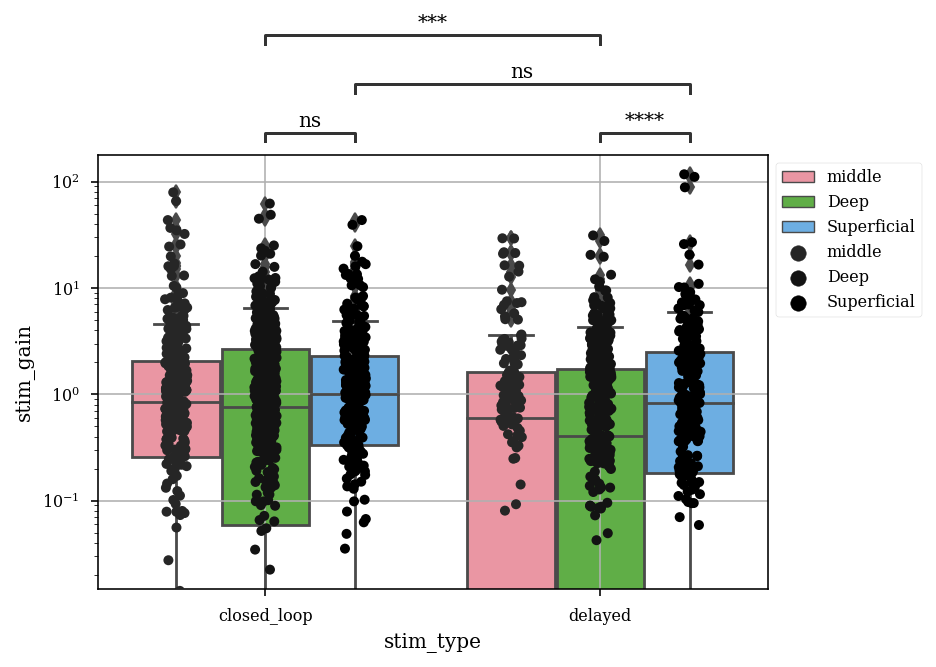

In [347]:
sns.boxplot(x='stim_type',y='stim_gain',hue="deepSuperficial",data=results)
sns.stripplot(x='stim_type',y='stim_gain',hue="deepSuperficial",data=results,dodge=True,color="black")
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "Superficial")),
    (("delayed", "Deep"),("delayed", "Superficial")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "Superficial"),("delayed", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="stim_type",
    y="stim_gain",
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.grid()
plt.show()


In [5]:
results

,baseline_fr,avg_before_stim_firing_rate,participation,avg_stim_firing_rate,avg_firing_rate_if_par,stim_type,UID,deepSuperficial,deepSuperficialDistance,stim_gain,stim_gain_before_during
0,0.034753,0.000000,0.000000,0.000000,NaN,closed_loop,1,middle,-20.000000,0.000000,NaN
1,0.896057,1.860465,0.139535,1.453488,10.416667,closed_loop,2,Deep,-32.592842,1.622094,0.781250
2,0.813525,2.616279,0.087209,1.104651,12.666667,closed_loop,4,middle,0.000000,1.357857,0.422222
3,0.875360,1.395349,0.063953,0.639535,10.000000,closed_loop,5,middle,-2.592842,0.730597,0.458333
4,0.342122,0.639535,0.017442,0.174419,10.000000,closed_loop,6,middle,-15.970780,0.509813,0.272727
...,...,...,...,...,...,...,...,...,...,...,...
2141,0.388939,0.000000,0.000000,0.000000,NaN,delayed,112,Deep,-178.470382,0.000000,NaN
2142,0.288623,0.000000,0.000000,0.000000,NaN,delayed,113,Deep,-88.470382,0.000000,NaN
2143,0.271007,0.105263,0.000000,0.000000,NaN,delayed,114,Deep,-78.470382,0.000000,0.000000
2144,2.391339,3.263158,0.378947,5.578947,14.722222,delayed,115,Superficial,44.599494,2.332981,1.709677


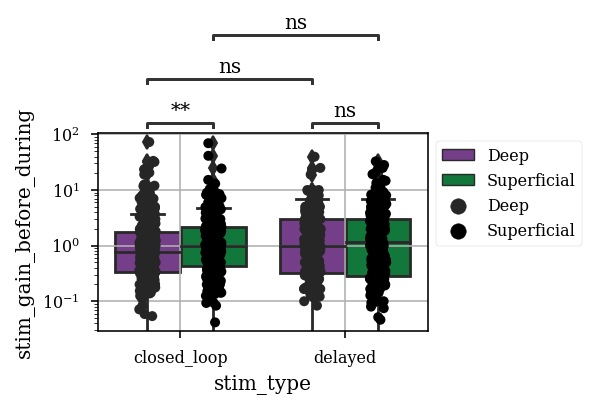

In [352]:
plt.figure(figsize=functions.set_size("thesis", fraction=.5, subplots=(1,1)))

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(x='stim_type',y='stim_gain_before_during',hue="deepSuperficial",hue_order=group_colors.keys(),data=results)
sns.stripplot(x='stim_type',y='stim_gain_before_during',hue="deepSuperficial",hue_order=group_colors.keys(), data=results,dodge=True,color="black")
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

box_pairs = [
    (("closed_loop", "Deep"),("closed_loop", "Superficial")),
    (("delayed", "Deep"),("delayed", "Superficial")),
    (("closed_loop", "Deep"),("delayed", "Deep")),
    (("closed_loop", "Superficial"),("delayed", "Superficial")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="stim_type",
    y="stim_gain_before_during",
    hue_order=group_colors.keys(),
    hue="deepSuperficial"
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.grid()
plt.show()


## make psth

In [6]:
psth = pd.DataFrame()
label_df = pd.DataFrame()
for basepath in df.basepath:
    manipulation_epochs = loading.load_manipulation(
        basepath, struct_name="optoStim", return_epoch_array=False
    )
    st, cm = loading.load_spikes(basepath, putativeCellType="Pyr", brainRegion="CA1")
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    for stim_type in manipulation_epochs.ev_label.unique():
        
        stim_epoch = nel.EpochArray([manipulation_epochs[manipulation_epochs.ev_label == stim_type][["start","stop"]].values])

        state_dict = loading.load_SleepState_states(basepath)
        wake_epochs = nel.EpochArray(state_dict["WAKEstate"])

        psth_temp = functions.compute_psth(
            st.data,
            stim_epoch[wake_epochs].starts,
            bin_width=0.005,
            n_bins=100,
        )

        psth = pd.concat([psth, psth_temp], axis=1)

        temp_df = pd.DataFrame()
        temp_df["brainRegion"] = cm.brainRegion.values
        temp_df["deepSuperficial"] = cm.deepSuperficial.values
        temp_df["UID"] = cm.UID.values
        temp_df["stim_type"] = stim_type
        temp_df["basepath"] = basepath

        label_df = pd.concat([label_df, temp_df], axis=0, ignore_index=True)


## get number of stim types per basepath

In [7]:
label_df["n_stim_type"] = label_df.basepath.map(
    label_df.groupby("basepath")
    .stim_type.apply(lambda x: x.nunique())
    .reset_index()
    .set_index("basepath")["stim_type"]
    .to_dict()
)
label_df


,brainRegion,deepSuperficial,UID,stim_type,basepath,n_stim_type
0,CA1,middle,1,closed_loop,Z:\Data\ORproject\OR15\day1,1
1,CA1,Deep,2,closed_loop,Z:\Data\ORproject\OR15\day1,1
2,CA1,middle,4,closed_loop,Z:\Data\ORproject\OR15\day1,1
3,CA1,middle,5,closed_loop,Z:\Data\ORproject\OR15\day1,1
4,CA1,middle,6,closed_loop,Z:\Data\ORproject\OR15\day1,1
...,...,...,...,...,...,...
1873,CA1so,Deep,112,closed_loop,Z:\Data\ORproject\OR23\day5,2
1874,CA1sp,Deep,113,closed_loop,Z:\Data\ORproject\OR23\day5,2
1875,CA1sp,Deep,114,closed_loop,Z:\Data\ORproject\OR23\day5,2
1876,CA1sr,Superficial,115,closed_loop,Z:\Data\ORproject\OR23\day5,2


## plotting helpers

In [292]:

def plot_psth_matrix(psth_df, label=None, ax=None, vmax=3, vmin=-3):

    psth = psth_df.values

    # psth_smooth = gaussian_filter1d(psth, np.round(.020 / np.diff(psth_df.index)[0]),axis=0)
    psth_smooth = psth

    if ax is None:
        plt.figure()
        ax = plt.gca()

    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    sm = ax.imshow(
        stats.zscore(psth_smooth, axis=0).T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr"
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm

def confidence_intervals(X, conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X), axis=1) == 0, :]
    # compute interval for each column
    interval = [
        stats.t.interval(conf, len(a) - 1, loc=np.mean(a), scale=stats.sem(a))
        for a in X.T
    ]
    interval = np.vstack(interval)
    lower = interval[:, 0]
    upper = interval[:, 1]
    return lower, upper

def plot_shaded_line(psth_df,group_colors,group_label,ax0, zscore=True):
    psth = psth_df.values
    if zscore:
        psth = stats.zscore(psth, axis=0)
    lower, upper = confidence_intervals(psth.T)
    ax0.plot(
        psth_df.index,
        np.nanmean(psth, axis=1),
        color=group_colors[group_label],
        linewidth=1,
    )
    ax0.fill_between(
        psth_df.index,
        lower,
        upper,
        color=group_colors[group_label],
        alpha=0.5,
        linewidth=0,
    )

## main psth fig

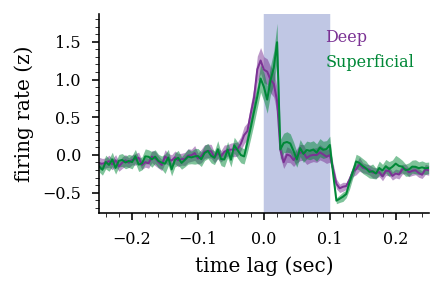

In [314]:
plt.figure(figsize=functions.set_size("thesis", fraction=.5, subplots=(1,1)),)
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()
idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.deepSuperficial == "Deep")
).values
# time_idx = (psth.index > -.1) & (psth.index < .2)
plot_shaded_line(psth.iloc[:, idx],group_colors,"Deep",ax)

idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.deepSuperficial == "Superficial")
).values
plot_shaded_line(psth.iloc[:, idx],group_colors,"Superficial",ax)

plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xlim(psth.index.min(), psth.index.max())

plt.axvspan(0, 0.1, color="#c0c7e4", alpha=1,zorder=-1000)

plt.ylabel('firing rate (z)')
plt.xlabel('time lag (sec)')
plt.legend(["Deep","Superficial"],labelcolor=group_colors.values(),loc="upper right",handlelength=0, handletextpad=0,frameon=False)    

sns.despine()

plt.savefig(
    os.path.join(fig_save_path, "ripple_just_closed_loop_deep_sup_psth.svg"),
    dpi=300,
    bbox_inches="tight",
)

## stim gain fig

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Deep vs. Superficial: Mann-Whitney-Wilcoxon test two-sided, P_val:2.518e-04 U_stat=4.504e+04


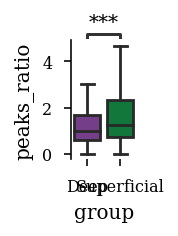

In [11]:
idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.deepSuperficial == "Deep")
).values
time_idx = (psth.index > 0) & (psth.index < .1)
deep_peaks_stim = psth.iloc[time_idx, idx].max(axis=0)

idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.deepSuperficial == "Deep")
).values
time_idx = (psth.index > -.1) & (psth.index < 0)
deep_peaks_pre_stim = psth.iloc[time_idx, idx].max(axis=0)

idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.deepSuperficial == "Superficial")
).values
time_idx = (psth.index > 0) & (psth.index < .1)
sup_peaks_stim = psth.iloc[time_idx, idx].max(axis=0)

idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.deepSuperficial == "Superficial")
).values
time_idx = (psth.index > -.1) & (psth.index < 0)
sup_peaks_pre_stim = psth.iloc[time_idx, idx].max(axis=0)

df_peaks = pd.DataFrame()
df_peaks["peaks"] = np.hstack([deep_peaks_stim, sup_peaks_stim])
df_peaks["pre_peaks"] = np.hstack([deep_peaks_pre_stim, sup_peaks_pre_stim])
df_peaks["peaks_ratio"] = df_peaks["peaks"] / df_peaks["pre_peaks"]
df_peaks["group"] = ["Deep"] * len(deep_peaks_stim) + ["Superficial"] * len(sup_peaks_stim)

plt.figure(figsize=functions.set_size("thesis", fraction=.1, subplots=(3, 1)))

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(x="group", y="peaks_ratio", data=df_peaks,showfliers=False)
# sns.stripplot(x="group", y="peaks_ratio", data=df_peaks, color="k", jitter=0.2, size=2)
# plt.yscale("log")
sns.despine(bottom=True)
box_pairs = [
    ("Superficial", "Deep")
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=df_peaks,
    x="group",
    y="peaks_ratio",
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

plt.savefig(
    os.path.join(fig_save_path, "ripple_closed_loop_deep_sup_psth_box_plot.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [14]:
df_peaks

,peaks,pre_peaks,peaks_ratio,group
0,6.976744,5.813953,1.200000,Deep
1,1.162791,1.162791,1.000000,Deep
2,1.162791,1.162791,1.000000,Deep
3,2.325581,3.488372,0.666667,Deep
4,3.488372,2.325581,1.500000,Deep
...,...,...,...,...
751,1.960784,3.921569,0.500000,Superficial
752,5.882353,5.882353,1.000000,Superficial
753,5.882353,7.843137,0.750000,Superficial
754,9.803922,5.882353,1.666667,Superficial


In [29]:
prop_sig_df = df_peaks.groupby(["group"]).apply(
    lambda x: pd.Series(
        {
            "prop": (x.peaks_ratio > 1.5).sum() / len(x.peaks_ratio),
            "counts": (x.peaks_ratio > 1.5).sum(),
            "nobs": len(x.peaks_ratio)
        }
    )
).reset_index()
prop_sig_df["constant"] = 1
prop_sig_df

,group,prop,counts,nobs,constant
0,Deep,0.224839,105.0,467.0,1
1,Superficial,0.394464,114.0,289.0,1


In [28]:
from statsmodels.stats.proportion import proportions_ztest
count = prop_sig_df.counts
nobs = prop_sig_df.nobs
stat, pval = proportions_ztest(count, nobs)
stat, pval

(-4.996283164971586, 5.844582335520873e-07)

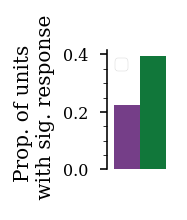

In [36]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

plt.figure(figsize=functions.set_size("thesis", fraction=.1, subplots=(3, 1)))

sns.barplot(data=prop_sig_df,x="constant",y="prop",hue="group",hue_order=group_colors.keys())
sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Prop. of units \n with sig. response")
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

plt.savefig(
    os.path.join(fig_save_path, "prop_closed_loop_unit_response.svg"),
    dpi=300,
    bbox_inches="tight",
)

## closed loop and delayed fig

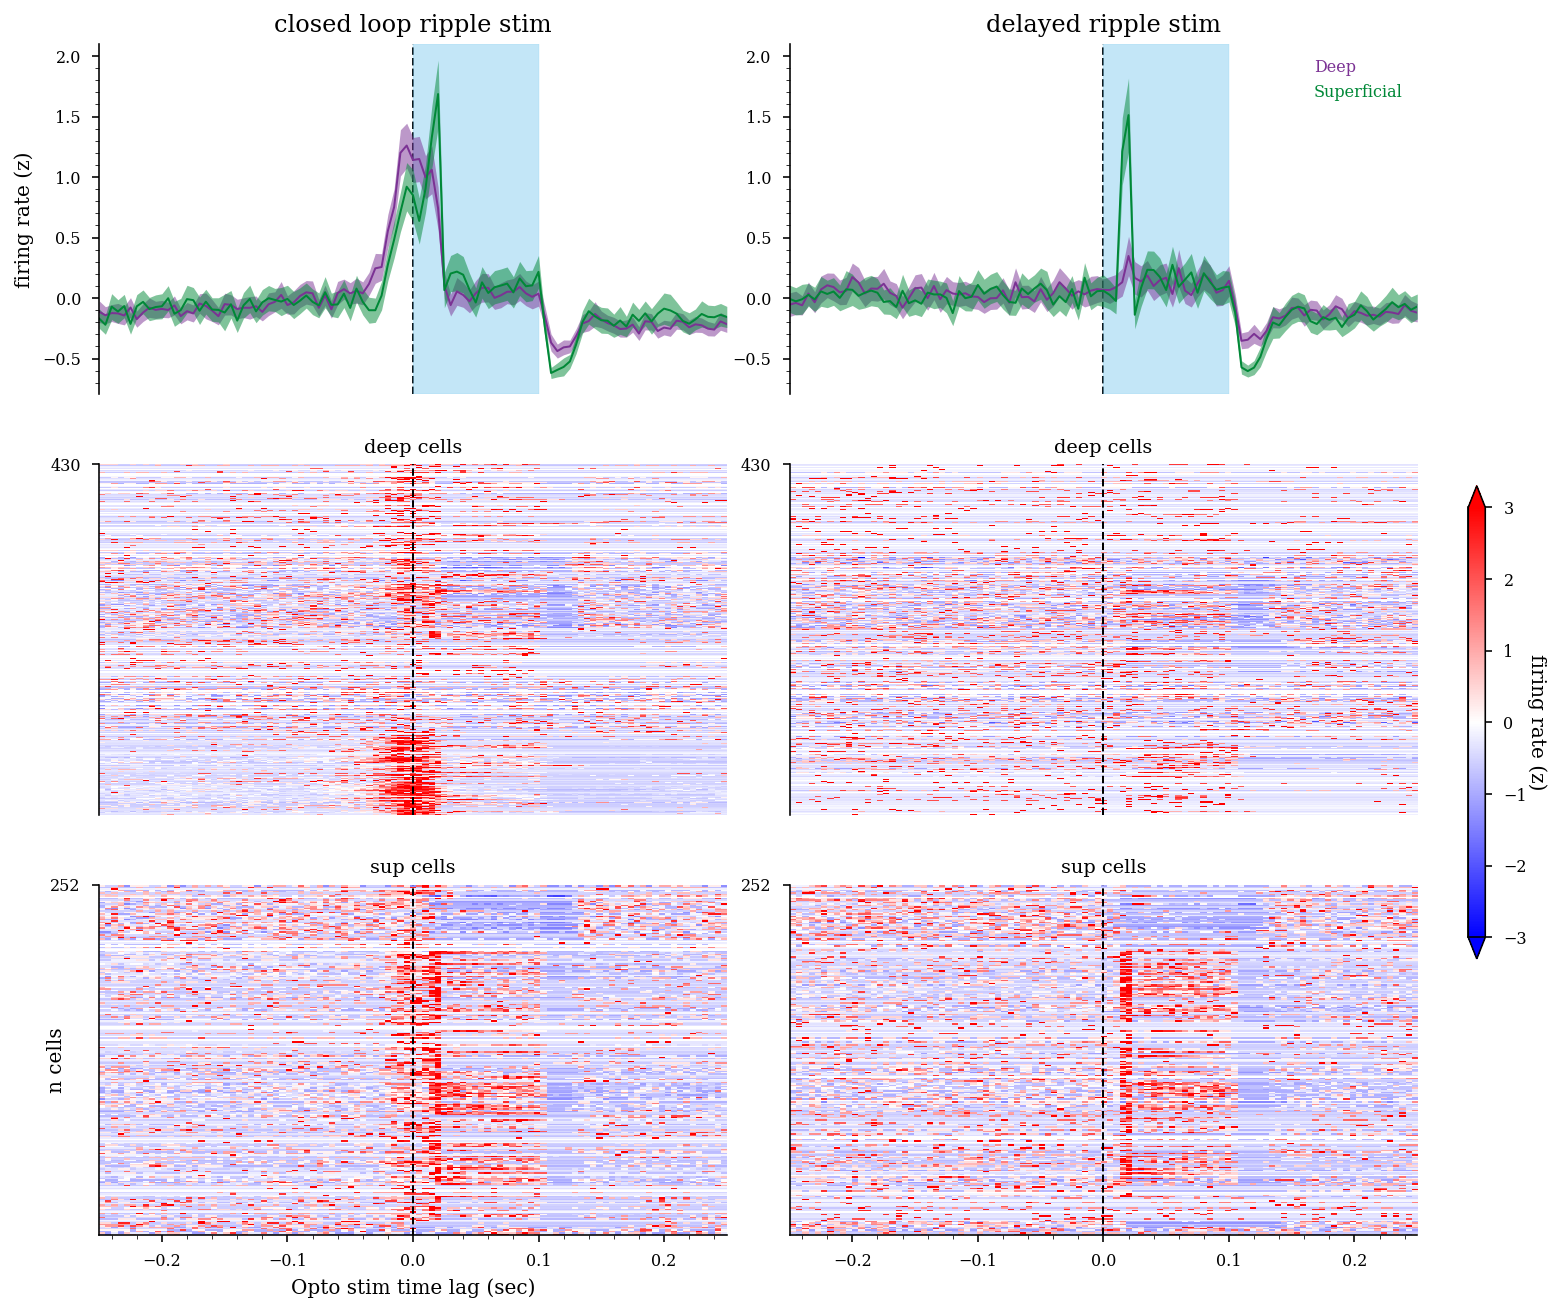

In [299]:
# plot_psth_matrix(psth_df, cell_metrics, region_idx, label=None, ax=None, vmax=3, vmin=-3)

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

fig, axs = plt.subplots(3,2,
    figsize=functions.set_size("thesis", fraction=2, subplots=(3, 2)),
    sharex=False,
)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
axs = axs.ravel()

idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.n_stim_type == 2)
    & (label_df.deepSuperficial == "Deep")
).values
plot_shaded_line(psth.iloc[:, idx],group_colors,"Deep",axs[0])
plot_psth_matrix(psth.iloc[:, idx], ax=axs[2])

idx = (
    (label_df.stim_type == "closed_loop")
    & (label_df.n_stim_type == 2)
    & (label_df.deepSuperficial == "Superficial")
).values
plot_shaded_line(psth.iloc[:, idx],group_colors,"Superficial",axs[0])
sm = plot_psth_matrix(psth.iloc[:, idx], ax=axs[4])



idx = (
    (label_df.stim_type == "delayed")
    & (label_df.n_stim_type == 2)
    & (label_df.deepSuperficial == "Deep")
).values
plot_shaded_line(psth.iloc[:, idx],group_colors,"Deep",axs[1])
plot_psth_matrix(psth.iloc[:, idx], ax=axs[3])

idx = (
    (label_df.stim_type == "delayed")
    & (label_df.n_stim_type == 2)
    & (label_df.deepSuperficial == "Superficial")
).values
plot_shaded_line(psth.iloc[:, idx],group_colors,"Superficial",axs[1])
plot_psth_matrix(psth.iloc[:, idx], ax=axs[5])

axs[0].set_title("closed loop ripple stim",fontsize=12)
axs[1].set_title("delayed ripple stim",fontsize=12)
axs[2].set_title("deep cells")
axs[3].set_title("deep cells")
axs[4].set_title("sup cells")
axs[5].set_title("sup cells")

axs[1].sharey(axs[0])
axs[0].set_xlim(psth.index.min(), psth.index.max())
axs[1].set_xlim(psth.index.min(), psth.index.max())

cax = plt.axes([.93, 0.3, 0.01, 0.3])
cbar = plt.colorbar(sm,cax=cax, extend='both')
cbar.set_label('firing rate (z)', rotation=270, labelpad=10)

axs[0].axvline(0, color="black", linestyle="--",lw=1,zorder=-1000)
axs[1].axvline(0, color="black", linestyle="--",lw=1,zorder=-1000)

axs[0].axvspan(0, 0.1, color="#89CFF0", alpha=0.5,zorder=-1000)
axs[1].axvspan(0, 0.1, color="#89CFF0", alpha=0.5,zorder=-1000)

axs[0].set_ylabel('firing rate (z)')
axs[4].set_xlabel('Opto stim time lag (sec)')
axs[4].set_ylabel('n cells',labelpad=-8)

for ax in axs:
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

sns.despine()
for i in range(4):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    

axs[1].legend(["Deep","Superficial"],labelcolor=group_colors.values(),loc="upper right",handlelength=0, handletextpad=0,frameon=False)    

plt.savefig(
    os.path.join(fig_save_path, "ripple_closed_loop_deep_sup_psth.jpeg"),
    dpi=300,
    bbox_inches="tight",
)

In [186]:
basepath = r"Z:\Data\ORproject\OR15\hc300118"
manipulation_epochs = loading.load_manipulation(
    basepath, struct_name="optoStim", return_epoch_array=False
)
st, cm = loading.load_spikes(basepath, putativeCellType="Pyr", brainRegion="CA1")
cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)
# manipulation_epochs,st

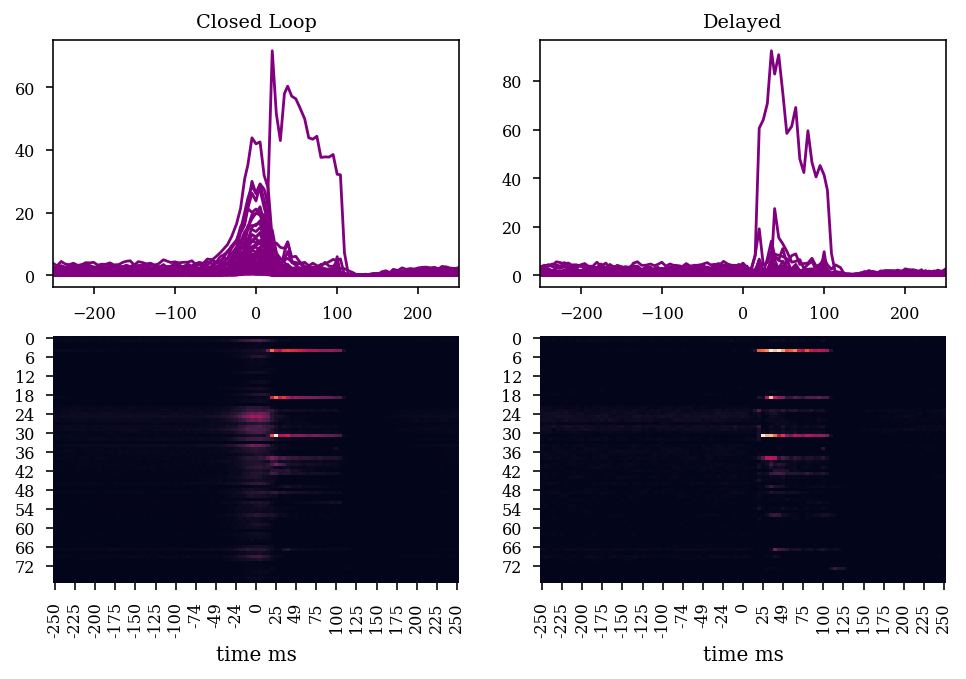

In [187]:
fig,ax = plt.subplots(2,2,figsize=(8,5))

closed_loop_psth = functions.compute_psth(st.data, manipulation_epochs[manipulation_epochs.ev_label == "closed_loop"].start.values, bin_width=0.005, n_bins=100)
closed_loop_psth.index = (closed_loop_psth.index*1000).astype(int)
closed_loop_psth.index.rename("time ms", inplace=True)

delayed_psth = functions.compute_psth(st.data, manipulation_epochs[manipulation_epochs.ev_label == "delayed"].start.values, bin_width=0.005, n_bins=100)
delayed_psth.index = (delayed_psth.index*1000).astype(int)
delayed_psth.index.rename("time ms", inplace=True)

ax[0,0].plot(closed_loop_psth.index,closed_loop_psth.iloc[:,cm.deepSuperficial.values=="Deep"],color="purple")
ax[0,0].plot(closed_loop_psth.index,closed_loop_psth.iloc[:,cm.deepSuperficial.values=="Superficial"],color="green")

# closed_loop_psth.plot(legend=False,ax=ax[0,0])
sns.heatmap(closed_loop_psth.T,ax=ax[1,0],cbar=False)

ax[0,1].plot(delayed_psth.index,delayed_psth.iloc[:,cm.deepSuperficial.values=="Deep"],color="purple")
ax[0,1].plot(delayed_psth.index,delayed_psth.iloc[:,cm.deepSuperficial.values=="Superficial"],color="green")

sns.heatmap(delayed_psth.T,ax=ax[1,1],cbar=False)

ax[0,0].set_xlim(closed_loop_psth.index.min(),closed_loop_psth.index.max())
ax[0,1].set_xlim(delayed_psth.index.min(),delayed_psth.index.max())

ax[0,0].set_title("Closed Loop")
ax[0,1].set_title("Delayed")
plt.show()

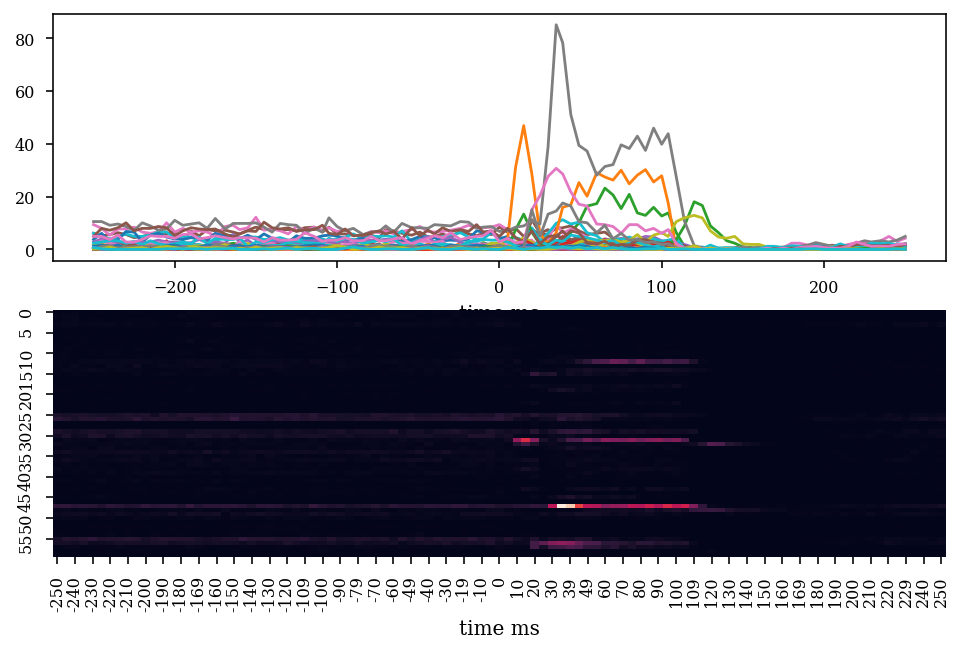

In [64]:
delayed_psth = functions.compute_psth(st.data, manipulation_epochs["delayed"].starts, bin_width=0.005, n_bins=100)
delayed_psth.index = (delayed_psth.index*1000).astype(int)
delayed_psth.index.rename("time ms", inplace=True)

fig,ax = plt.subplots(2,1,figsize=(8,5))
delayed_psth.plot(legend=False,ax=ax[0])
sns.heatmap(delayed_psth.T,ax=ax[1],cbar=False)
plt.show()

## testing below

In [4]:
manipulation_epochs = loading.load_manipulation(
    basepath, struct_name="optoStim",return_epoch_array=False
)

display(manipulation_epochs)

manipulation_epochs = loading.load_manipulation(
    basepath, struct_name="optoStim",return_epoch_array=True
)

display(manipulation_epochs)

,start,stop,peaks,center,duration,amplitude,amplitudeUnits,ev_label
0,3.41255,3.51255,3.46255,3.46255,0.1,NaN,au,closed_loop
1,10.43515,10.53515,10.48515,10.48515,0.1,NaN,au,closed_loop
2,22.50845,22.60845,22.55845,22.55845,0.1,NaN,au,closed_loop
3,34.28070,34.38070,34.33070,34.33070,0.1,NaN,au,closed_loop
4,37.22515,37.32515,37.27515,37.27515,0.1,NaN,au,closed_loop
...,...,...,...,...,...,...,...,...
4747,21327.19765,21327.29765,21327.24765,21327.24765,0.1,NaN,au,delayed
4748,21366.13200,21366.23200,21366.18200,21366.18200,0.1,NaN,au,delayed
4749,21491.72590,21491.82590,21491.77590,21491.77590,0.1,NaN,au,delayed
4750,21510.06840,21510.16840,21510.11840,21510.11840,0.1,NaN,au,delayed


{'closed_loop': <EpochArray at 0x19a4851fb20: 3,646 epochs> of length 6:04:600 minutes,
 'delayed': <EpochArray at 0x19a4851fac0: 1,106 epochs> of length 1:50:600 minutes}

In [5]:
st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")
cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)


In [6]:
fr_mat = functions.get_participation(st.data,manipulation_epochs['closed_loop'].starts, manipulation_epochs['closed_loop'].stops,par_type="binary")

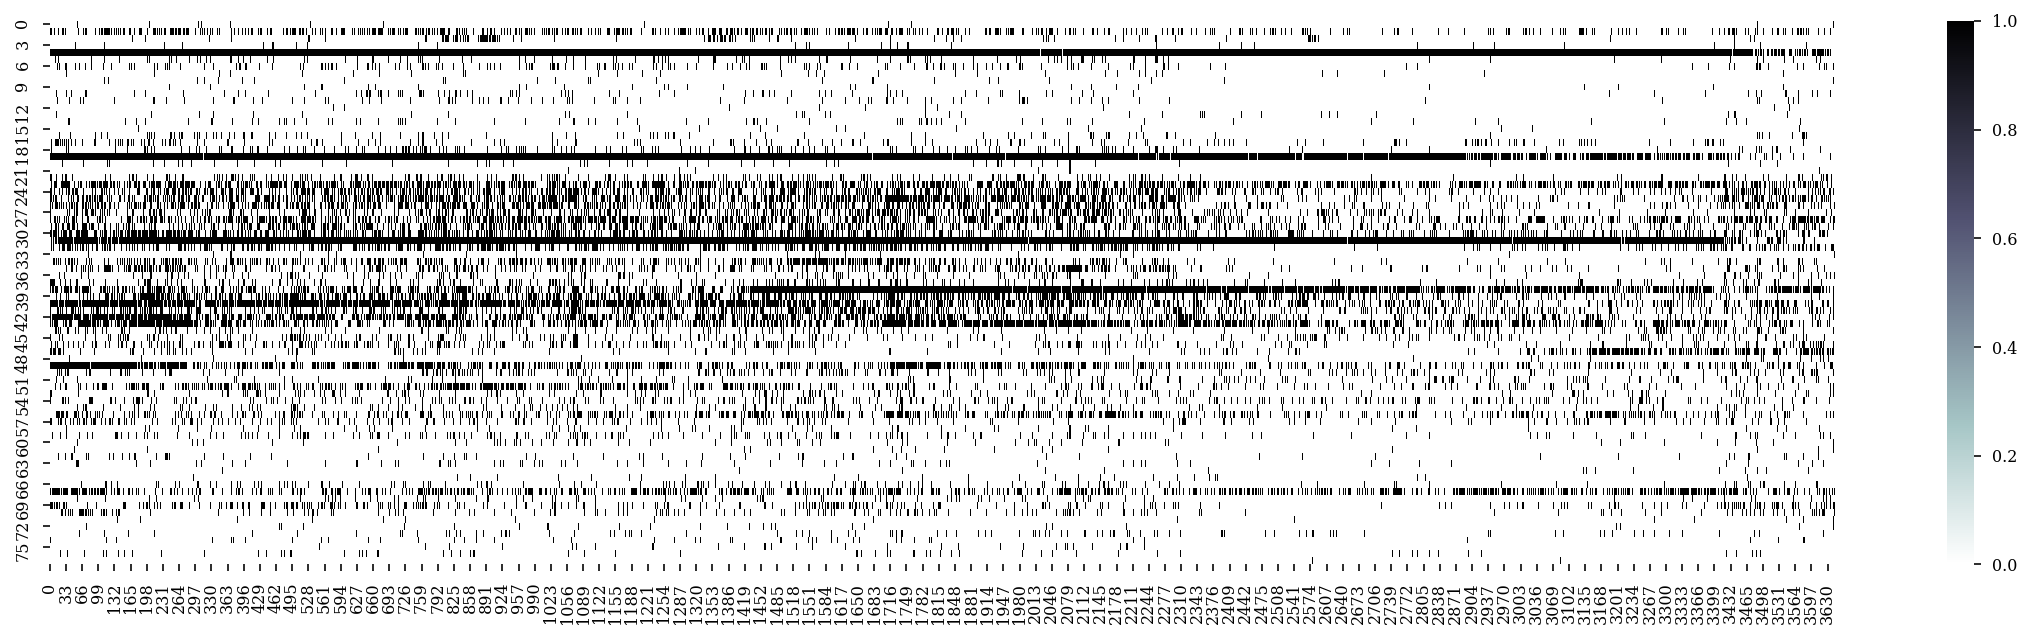

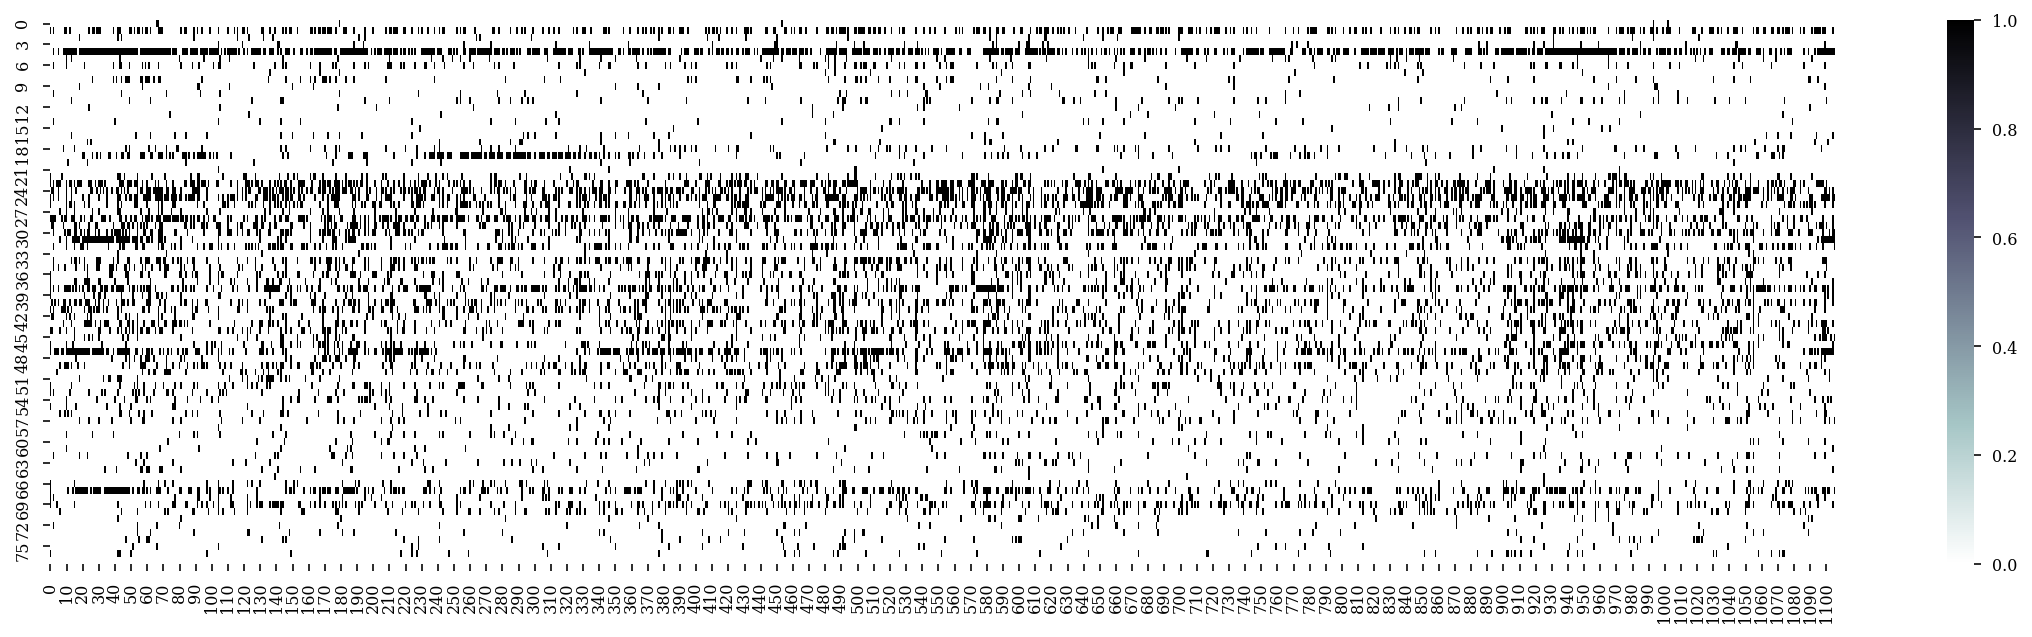

In [7]:
closed_loop = functions.get_participation(st.data,manipulation_epochs['closed_loop'].starts, manipulation_epochs['closed_loop'].stops,par_type="binary")
plt.figure(figsize=(20,5))
sns.heatmap(closed_loop,cmap="bone_r")
plt.show()

delayed = functions.get_participation(st.data,manipulation_epochs['delayed'].starts, manipulation_epochs['delayed'].stops,par_type="binary")
plt.figure(figsize=(20,5))
sns.heatmap(delayed,cmap="bone_r")
plt.show()

In [8]:
df = pd.DataFrame()
df['participation'] = np.hstack([closed_loop.mean(axis=1),delayed.mean(axis=1)])
df['stim_type'] = np.hstack([np.repeat('closed_loop',closed_loop.shape[0]),np.repeat('delayed',delayed.shape[0])])
df['deepSuperficial'] = np.hstack([cm.deepSuperficial,cm.deepSuperficial])
df['deepSuperficialDistance'] = np.hstack([cm.deepSuperficialDistance,cm.deepSuperficialDistance])

df

,participation,stim_type,deepSuperficial,deepSuperficialDistance
0,0.006308,closed_loop,Deep,-145.736540
1,0.271530,closed_loop,Deep,-165.686232
2,0.052386,closed_loop,middle,-28.817655
3,0.016731,closed_loop,Deep,-195.604452
4,0.978881,closed_loop,Deep,-145.604452
...,...,...,...,...
151,0.038879,delayed,middle,-28.817655
152,0.036166,delayed,Deep,-115.736540
153,0.028029,delayed,middle,11.182345
154,0.046112,delayed,Deep,-155.604452


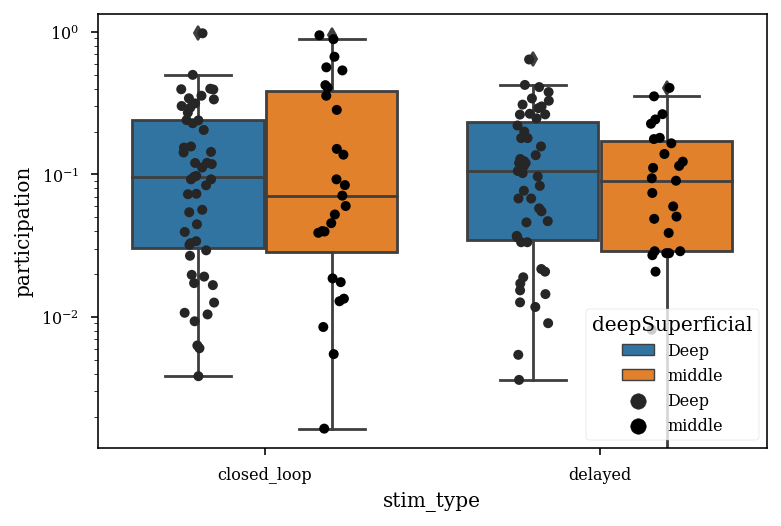

In [11]:
sns.boxplot(x='stim_type',y='participation',hue="deepSuperficial",data=df)
sns.stripplot(x='stim_type',y='participation',hue="deepSuperficial",data=df,dodge=True,color="black")
plt.yscale('log')

<AxesSubplot:xlabel='deepSuperficialDistance', ylabel='participation'>

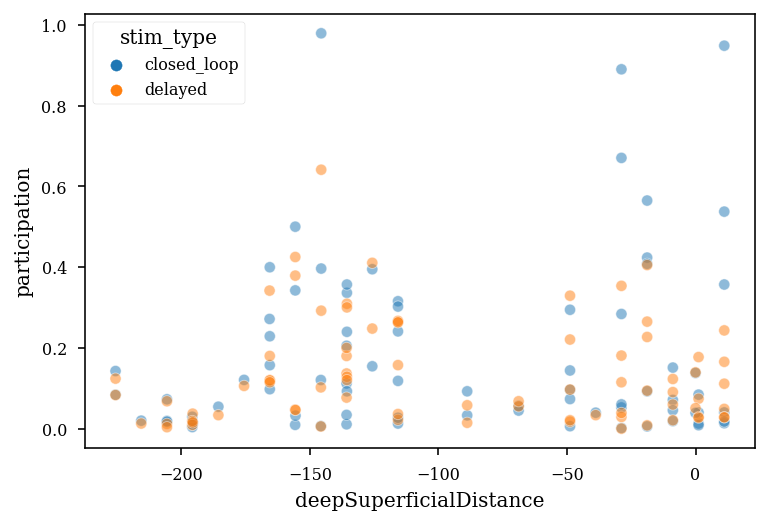

In [10]:
sns.scatterplot(x='deepSuperficialDistance',y='participation',hue='stim_type',data=df,alpha=0.5)

(0.0, 1.0)

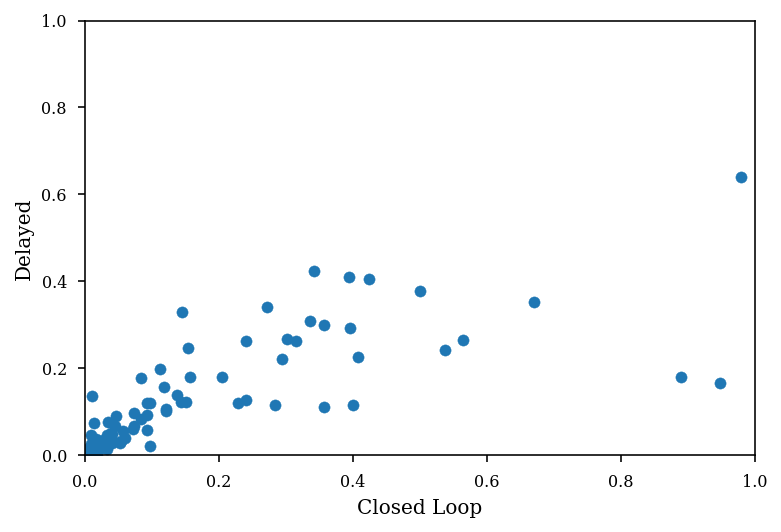

In [104]:
plt.scatter(closed_loop.mean(axis=1),delayed.mean(axis=1))
plt.xlabel("Closed Loop")
plt.ylabel("Delayed")
plt.xlim([0,1])
plt.ylim([0,1])

In [ ]:
pearson = np.corrcoef(closed_loop,delayed)

sns.heatmap(pearson,cmap="RdBu_r",vmin=-.5,vmax=.5)